In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from itertools import combinations
from scipy.special import comb
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

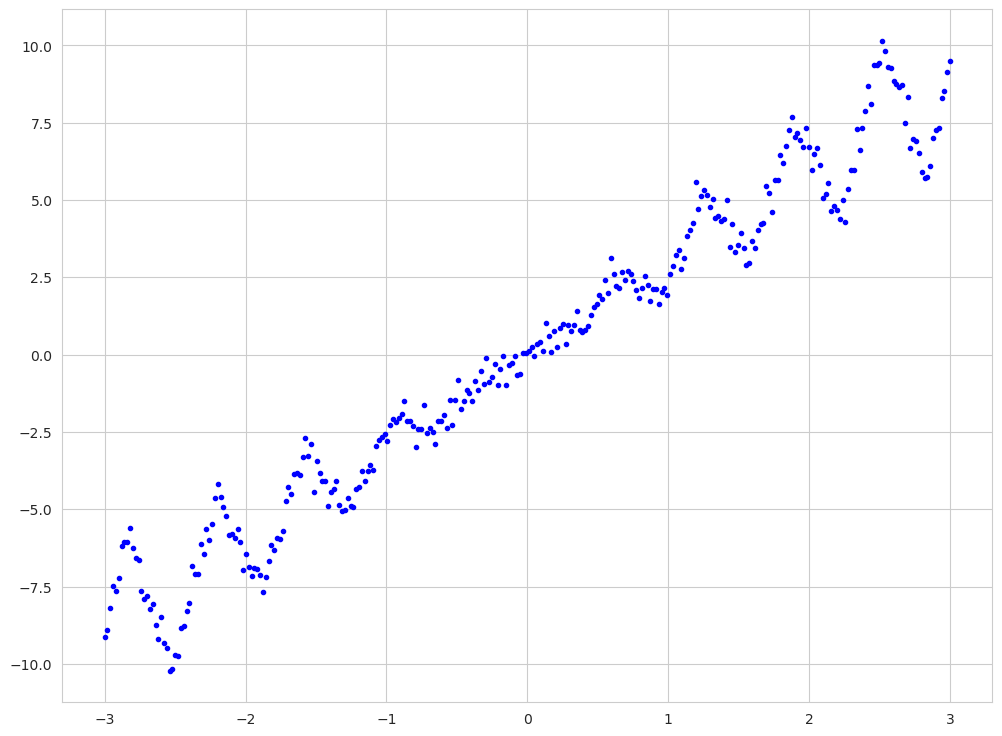

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(X, y, "b.", linewidth=3)
    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")
    plt.legend(loc="upper left", fontsize=16)

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

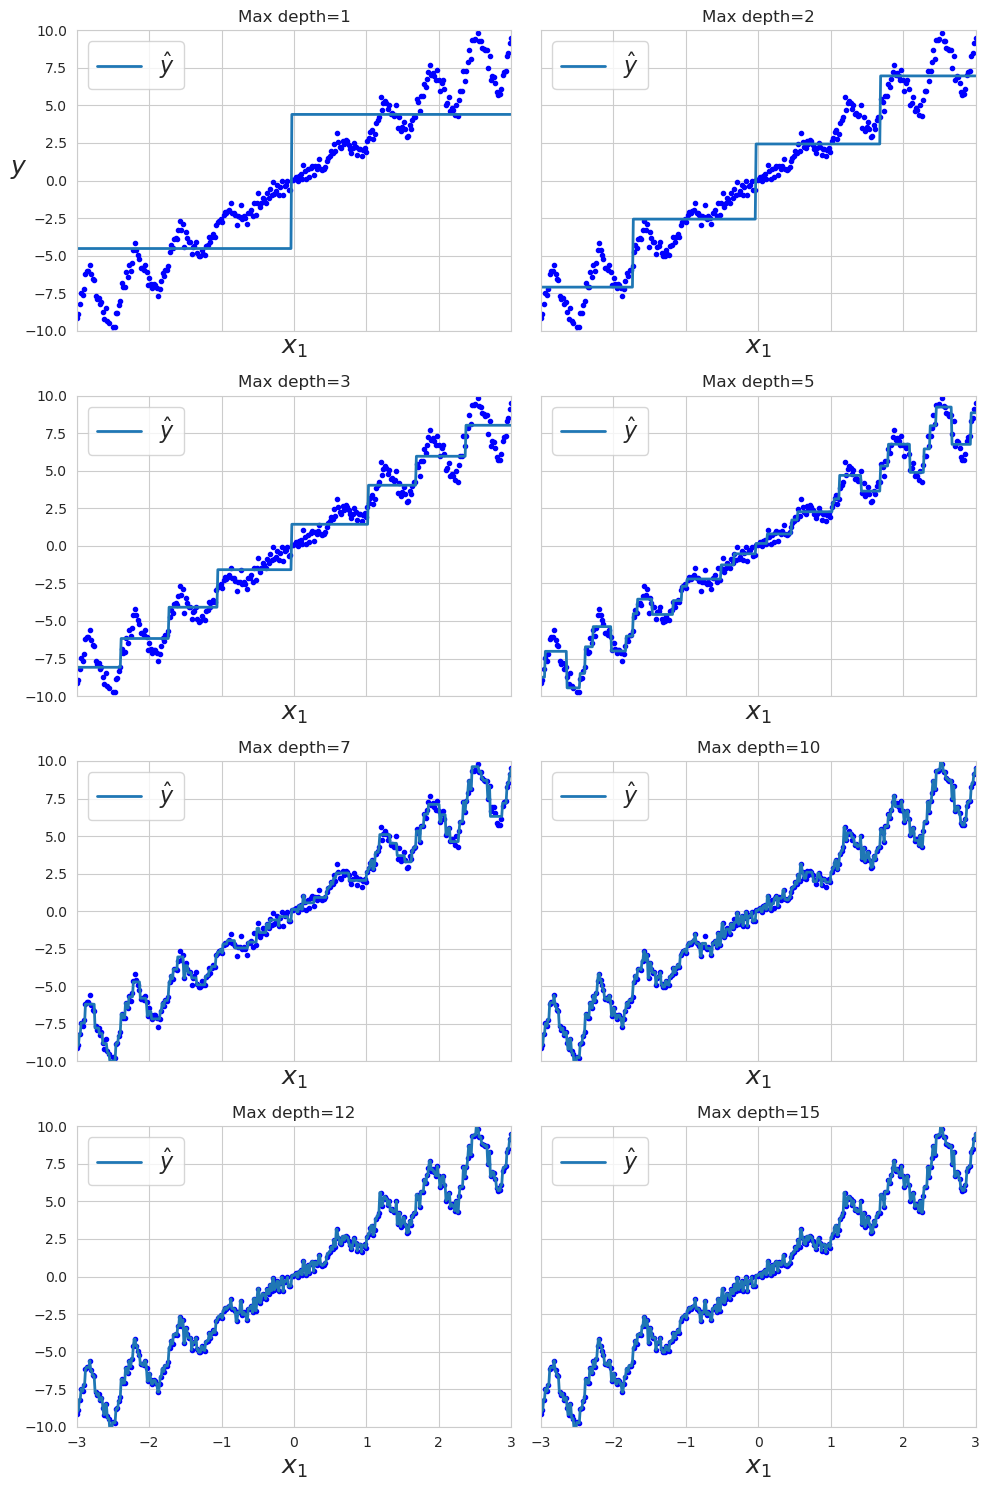

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15), sharex=True, sharey=True)
for depth, ax in zip([1, 2, 3, 5, 7, 10, 12, 15], axes.flatten()):
    tree_reg = DecisionTreeRegressor(max_depth=depth)
    tree_reg.fit(X, y)
    plt.sca(ax)
    plot_regression_predictions(tree_reg, X, y, ylabel=None if ax != axes[0, 0] else "$y$")
    plt.title(f"Max depth={depth}")

plt.tight_layout()
plt.show()

На графиках с глубиной 1,2,3 очень высокий bias и неадекватная аппроксимация данных. При этом глубине выше 10 уже очень высокий variance и модель переобучается. Кажется, что оптимальная глубина в данном случае находится в диапазоне 4-5.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

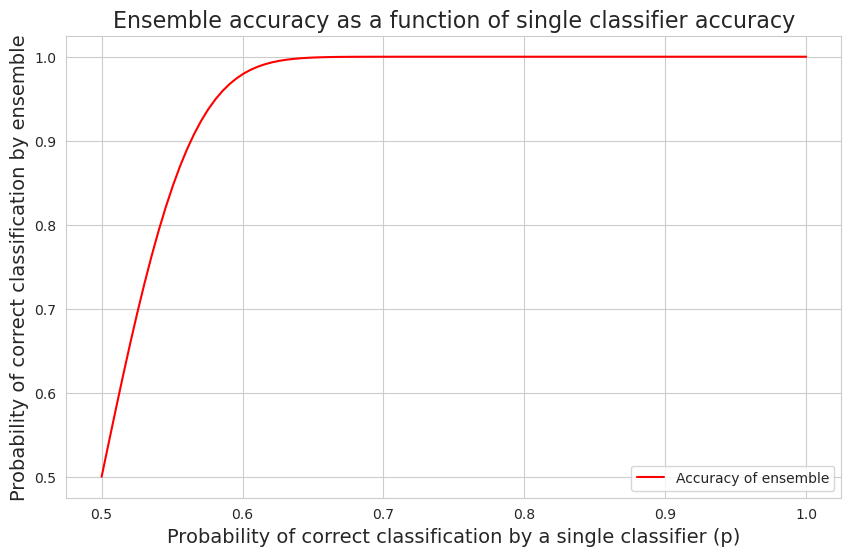

In [6]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
def ensemble_accuracy(p, N):
    return sum(comb(N, i) * p**i * (1-p)**(N-i) for i in range(int(np.ceil(N/2)), N+1))

N = 101
ps = np.linspace(0.5, 1, 100)
accuracies_updated = [ensemble_accuracy(p, N) for p in ps]

plt.figure(figsize=(10, 6))
plt.plot(ps, accuracies_updated, label="Accuracy of ensemble", color='red')
plt.xlabel("Probability of correct classification by a single classifier (p)", fontsize=14)
plt.ylabel("Probability of correct classification by ensemble", fontsize=14)
plt.title("Ensemble accuracy as a function of single classifier accuracy", fontsize=16)
plt.grid(True)
plt.legend()
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

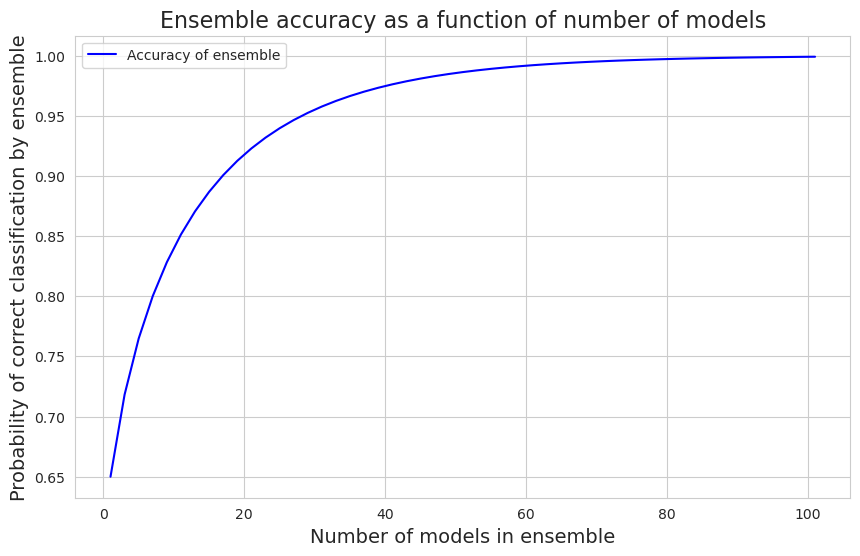

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
Ns = range(1, 102, 2)
fixed_p = 0.65
accuracies = [ensemble_accuracy(fixed_p, N) for N in Ns]
plt.figure(figsize=(10, 6))
plt.plot(Ns, accuracies, label="Accuracy of ensemble", color='blue')
plt.xlabel("Number of models in ensemble", fontsize=14)
plt.ylabel("Probability of correct classification by ensemble", fontsize=14)
plt.title("Ensemble accuracy as a function of number of models", fontsize=16)
plt.grid(True)
plt.legend()
plt.show()

Опишите ваши наблюдения:

* чем выше точность каждого отдельного дерева в ансамбле, тем выше суммарная точность классификации
* чем больше классификаторов (деревьев) в ансамбле, тем выше итоговая точность классификации

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [8]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))

        n_features = X.shape[1]
        n_samples = X.shape[0]

        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            
            # Выбор признаков без возвращения
            if self.max_features is None:
                self.max_features = n_features
            features_choice = np.random.choice(n_features, self.max_features, replace=False)
            self.feat_ids_by_tree.append(features_choice)
            
            # Создание псевдовыборки с возвращением
            sample_choice = np.random.choice(n_samples, n_samples, replace=True)
            X_sampled = X[sample_choice][:, features_choice]
            y_sampled = y[sample_choice]
            
            # Обучение дерева
            tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_sampled, y_sampled)
            self.trees.append(tree)
            
        return self

    def predict_proba(self, X):
        probas = np.array([tree.predict_proba(X[:, self.feat_ids_by_tree[i]]) for i, tree in enumerate(self.trees)])
        avg_probas = np.mean(probas, axis=0)
        return avg_probas
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [9]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

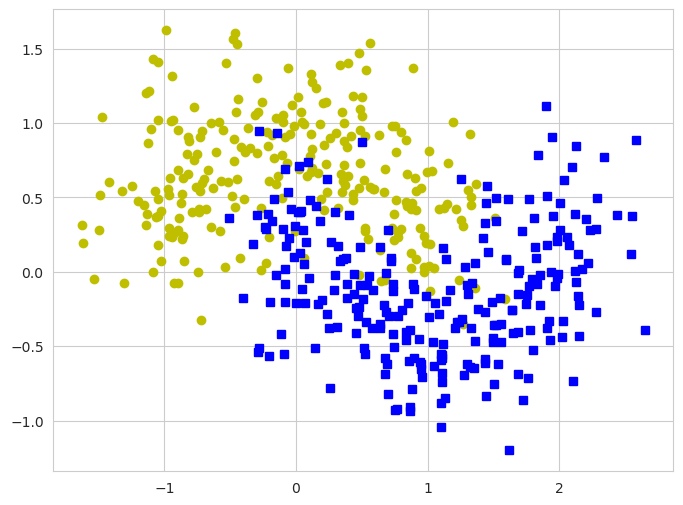

In [10]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

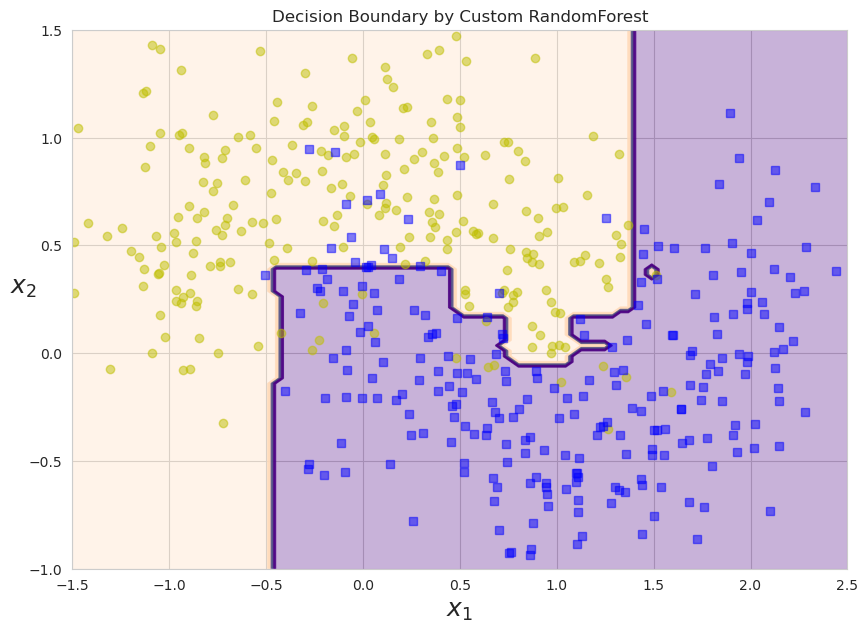

In [11]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

custom_rf_clf = RandomForestClassifierCustom(n_estimators=100, max_depth=5, random_state=SEED)
custom_rf_clf.fit(X, y)

plt.figure(figsize=(10, 7))
plot_decision_boundary(custom_rf_clf, X, y)
plt.title("Decision Boundary by Custom RandomForest")
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

Лучшие параметры: {'max_depth': 10, 'max_features': None, 'n_estimators': 100} лучшее значение F1-меры: 0.9174864971417307


Text(0.5, 1.0, 'Decision Boundary by Custom RandomForest with Best Params')

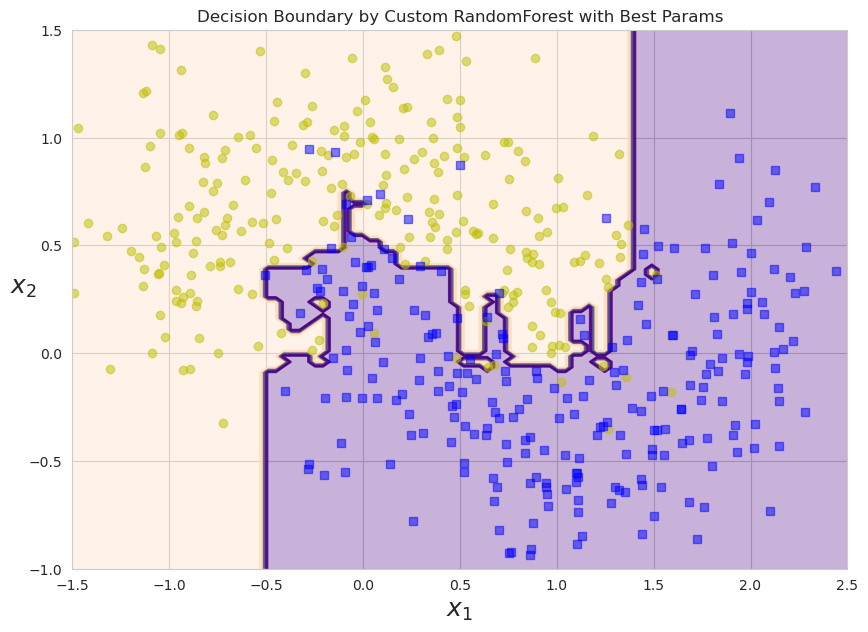

In [13]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [1, 3, 5, 10, 15],
    'max_features': ['sqrt', 'log2', None]
}

my_rf_clf = RandomForestClassifierCustom(random_state=SEED)

grid_search = GridSearchCV(my_rf_clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_, "лучшее значение F1-меры:", grid_search.best_score_)

# Обучаем модель с лучшими параметрами на всем обучающем наборе
best_rf_clf = grid_search.best_estimator_

# Визуализируем разделяющую границу для модели с лучшими параметрами
plt.figure(figsize=(10, 7))
plot_decision_boundary(best_rf_clf, X, y)
plt.title("Decision Boundary by Custom RandomForest with Best Params")

In [14]:
y_pred = best_rf_clf.predict(X_test)

# Вычисляем F1-меру
f1 = f1_score(y_test, y_pred, average='binary') 
print(f'F1 score: {f1}')

F1 score: 0.92


#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [15]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [16]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

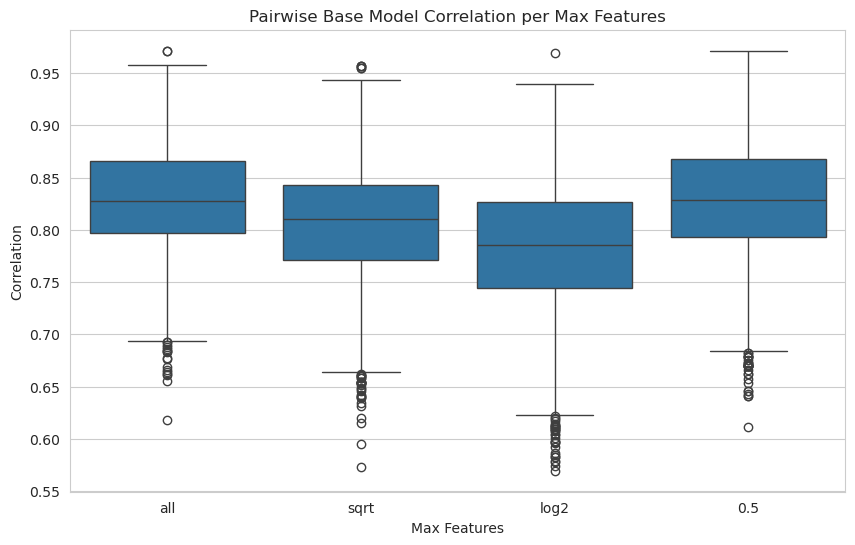

In [17]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

# Параметры max_features
max_features_params = [None, 'sqrt', 'log2', 0.5]

# Словарь для хранения корреляций для разных max_features
corrs_by_max_features = {}

# Обучаем модели с разными max_features и считаем корреляции
for max_features in max_features_params:
    rf = RandomForestClassifier(n_estimators=100, max_features=max_features, random_state=42)
    rf.fit(X_train, y_train)
    corrs = base_model_pair_correlation(rf, X_test)
    corrs_by_max_features[max_features if max_features is not None else "all"] = corrs

corrs_flattened = []
models = []
for max_features, corrs in corrs_by_max_features.items():
    corrs_flattened.extend(corrs)
    models.extend([max_features] * len(corrs))

# Создаем DataFrame
df_corrs = pd.DataFrame({
    'Correlation': corrs_flattened,
    'Max Features': models
})

# Визуализация с Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Max Features', y='Correlation', data=df_corrs)
plt.title('Pairwise Base Model Correlation per Max Features')
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

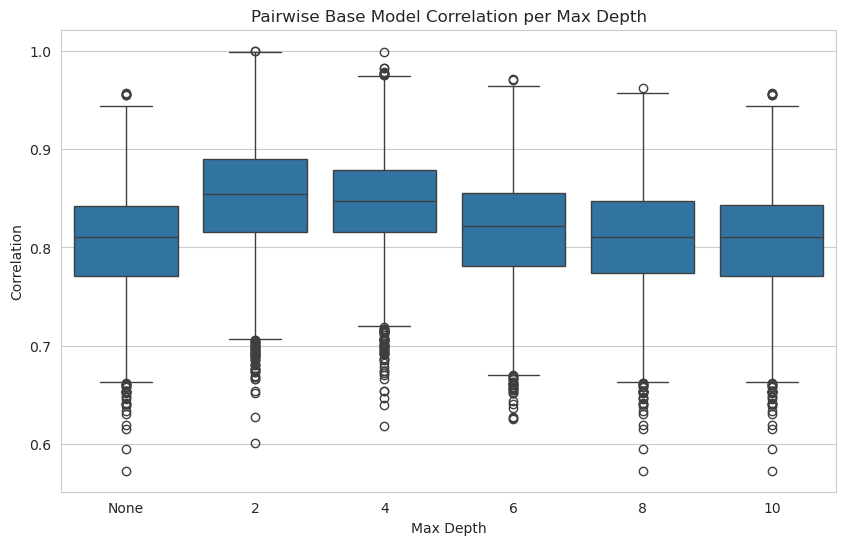

In [18]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
# Параметры max_depth
max_depth_params = [None, 2, 4, 6, 8, 10]

# Словарь для хранения корреляций для разных max_depth
corrs_by_max_depth = {}

# Обучаем модели с разными max_depth и считаем корреляции
for max_depth in max_depth_params:
    rf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=42)
    rf.fit(X_train, y_train)
    corrs = base_model_pair_correlation(rf, X_test)
    corrs_by_max_depth[max_depth if max_depth is not None else "None"] = corrs

# Подготовка данных для Seaborn
corrs_flattened = []
depths = []
for max_depth, corrs in corrs_by_max_depth.items():
    corrs_flattened.extend(corrs)
    depths.extend([str(max_depth)] * len(corrs))

df_corrs = pd.DataFrame({
    'Correlation': corrs_flattened,
    'Max Depth': depths
})

# Визуализация с Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Max Depth', y='Correlation', data=df_corrs)
plt.title('Pairwise Base Model Correlation per Max Depth')
plt.show()

Опишите ваши наблюдения:

* в случае параметра max_features. Ожидаемое поведение было: чем меньше параметр max_fetures, тем больше деревья отличаются друг от друга, тем менее скоррелированы должны быть итоговые предсказания. В целом мы видим снижение корреляции при переходе от all max_fetures к не всем признакам (sqrt, log2), однако это снижение не то, чтобы очень значительное. Однако если брать max_features, то полученное медианное значение корреляций почти не отличается от того, как если бы мы взяли все признаки, хотя разброс уменьшается.
* Чем больше глубина деревьев, тем более деревья разнообразны и тем менее их предсказания скоррелированы между собой. Однако с какого-то определенного значения max_depth корреляция перестает снижаться: видно, что для max_depth = 8, 10 и в отсутствии ограничений на max_depth степень скоррелированности предсказаний разных деревьев больше не снижается. 

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [28]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

/bin/bash: строка 1: gdown: команда не найдена


In [29]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [ ]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]
models_to_exclude = [("XGB_RF", xgb_rf), ("LR", lr)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')


## END YOUR CODE HERE ##
results = {}
for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")
results 

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

{}

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [ ]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_soft.fit(X_train, y_train)
correlations = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)
# Выводим пары сильно коррелирующих моделей
high_correlation_pairs = [(pair[0], pair[1], pair[2]) for pair in correlations if pair[2] > 0.8]
high_correlation_pairs


[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.225666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  RandomForestClassifier(n_estimators=50, random_state=111),
  0.8134894007824364),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  LGBMClassifier(random_state=111),
  0.8282760696670941),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',
                 random_state=111),
  0.8612656428887722),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learnin

In [ ]:
# Сортировка корреляций по убыванию
high_correlation_pairs_sorted = sorted(high_correlation_pairs, key=lambda x: x[2], reverse=True)

# Вывод отсортированных корреляций
for pair in high_correlation_pairs_sorted:
    print(f"{pair[0].__class__.__name__} - {pair[1].__class__.__name__}: {pair[2]}")



LGBMClassifier - XGBClassifier: 0.970838692549758
CatBoostClassifier - LGBMClassifier: 0.9552781313087828
ExtraTreesClassifier - CatBoostClassifier: 0.9527199736215165
SVC - LogisticRegression: 0.9521587816734959
CatBoostClassifier - XGBRFClassifier: 0.9454804718176699
RandomForestClassifier - CatBoostClassifier: 0.9450698035153566
LGBMClassifier - XGBRFClassifier: 0.9393402441419185
RandomForestClassifier - XGBRFClassifier: 0.9366030097279698
XGBClassifier - XGBRFClassifier: 0.9341115110090191
CatBoostClassifier - XGBClassifier: 0.9339896573127269
LGBMClassifier - XGBRFClassifier: 0.9318146314104278
RandomForestClassifier - ExtraTreesClassifier: 0.9215651183028867
RandomForestClassifier - LGBMClassifier: 0.9146873011990887
RandomForestClassifier - LGBMClassifier: 0.9146686698479999
ExtraTreesClassifier - XGBRFClassifier: 0.8977047690966479
RandomForestClassifier - XGBClassifier: 0.8966406332594105
ExtraTreesClassifier - LGBMClassifier: 0.8928745278265378
LogisticRegression - GaussianN

In [ ]:
models_to_exclude = [("ETC", etc), ("CAT", cat)]
filtered_base_models = [model for model in base_models if model not in models_to_exclude]
voting_clf_filtered = VotingClassifier(estimators=filtered_base_models, voting='soft')
voting_clf_filtered.fit(X_train, y_train)
f1_score_mean_filtered = cross_val_score(voting_clf_filtered, X_train, y_train, cv=5, scoring="f1").mean()


[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [ ]:
print(f1_score_mean_filtered)

0.855745645776041


Скора выше 0.87 достичь не удалось. Но если исключить из модели ExtraTreesClassifier - CatBoostClassifier, то скор вырастет с 0.846 до 0.856

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)/

In [19]:
data = pd.read_csv("../data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

Данные:
- State: Штат проживания пользователя.
- Account Length: Длительность использования аккаунта.
- Area Code: Телефонный код региона.
- Phone: Номер телефона.
- Int'l Plan: Наличие международного тарифного плана (да/нет).
- VMail Plan: Наличие тарифного плана с голосовой почтой (да/нет).
- VMail Message: Количество сообщений голосовой почты.
- Day Mins, Day Calls, Day Charge: Длительность, количество звонков и стоимость звонков днем.
- Eve Mins, Eve Calls, Eve Charge: Длительность, количество звонков и стоимость звонков вечером.
- Night Mins, Night Calls, Night Charge: Длительность, количество звонков и стоимость звонков ночью.
- Intl Mins, Intl Calls, Intl Charge: Длительность, количество и стоимость международных звонков.
- CustServ Calls: Количество обращений в службу поддержки.
- Churn?: Ушел ли клиент (целевая переменная)

Категориальные признаки Int'l Plan и VMail Plan перекодирую в с помощью label encoding.

Признак Phone использовать не буду, т.к. он уникальный для каждого пользователя. И State тоже выкину.

Churn надо перекодировать из object в int


In [43]:
# Кодирование категориальных переменных
le = LabelEncoder()
data['Int\'l Plan'] = le.fit_transform(data['Int\'l Plan'])
data['VMail Plan'] = le.fit_transform(data['VMail Plan'])
data['Churn?'] = le.fit_transform(data['Churn?'])

# Удаление ненужных столбцов
data_prepared = data.drop(['State', 'Phone'], axis=1)
data_prepared.head()


,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [50]:
# Разделение данных на обучающую и тестовую выборки
X = data_prepared.drop('Churn?', axis=1)
y = data_prepared['Churn?']


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [58]:
# Настройка модели XGBoost
xgb_params = {
    'n_estimators': [100, 200], # число деревьев в ансамбле
    'learning_rate': [0.01, 0.1], # темп обучения (уменьшение вклада каждого отдельного дерева)
    'max_depth': [3, 5, 7], # максимальная глубина дерева
    'subsample': [0.8, 1], # доля выборки, используемая для обучения 
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='accuracy')

In [69]:
# Настройка модели LightGBM Random Forest
lgb_params = {
    'boosting_type': ['rf'],  # алгоритмы бустинга. Я выберу random forest, потому что мне нужен случайный лес
    'n_estimators': [100, 200], # число деревьев в ансамбле
    'learning_rate': [0.01, 0.1], # скорость обучения
    'subsample': [0.8, 1], # доля выборки, используемая для обучения
    'subsample_freq': [1], # частота использования подвыборки
}
lgb_rf = LGBMClassifier()
lgb_rf_grid = GridSearchCV(lgb_rf, lgb_params, cv=3, scoring='accuracy', n_jobs=-1)
lgb_rf_grid.fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 247, number of negative: 1530


[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 246, number of negative: 1531
[LightGBM] [Info] Number of positive: 246, number of negative: 1531
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 247, number of negative: 1531
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 247, number of negative: 1530
[LightGBM] [Info] Number of positive: 247, number of negative: 1531
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .



[LightGBM] [Info] Number of positive: 247, number of negative: 1530
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.383237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 1777, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.138436 -> initscore=-1.828345
[LightGBM] [Info] Start training from score -1.828345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.317659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2328
[LightGBM] [Info] Number of data points in the train set: 1777, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.138998 -> initscore=-1.823635
[LightGBM] [Info] Start training from score -1.823635
[LightGBM] [Info] Auto-c

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 246, number of negative: 1531


[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 247, number of negative: 1531


[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 247, number of negative: 1530
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.370641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2328
[LightGBM] [Info] Number of data points in the train set: 1777, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.138998 -> initscore=-1.823635
[LightGBM] [Info] Start training from score -1.823635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 247, number of negative: 1531
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .



[LightGBM] [Info] Number of positive: 247, number of negative: 1530
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2328
[LightGBM] [Info] Number of data points in the train set: 1777, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.138998 -> initscore=-1.823635
[LightGBM] [Info] Start training from score -1.823635
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 246, number of negative: 1531
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.365346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 1777, number of used features: 18
[LightGBM]

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 246, number of negative: 1531
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .



[LightGBM] [Info] Number of positive: 247, number of negative: 1531


[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'boosting_type': ['rf'], 'learning_rate': [0.01, 0.1],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1],
                         'subsample_freq': [1]},
             scoring='accuracy')

In [70]:
(xgb_grid.best_score_, xgb_grid.best_params_), (lgb_rf_grid.best_score_, lgb_rf_grid.best_params_)

((0.9512392032077072,
  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}),
 (0.9279874644047873,
  {'boosting_type': 'rf',
   'learning_rate': 0.01,
   'n_estimators': 100,
   'subsample': 0.8,
   'subsample_freq': 1}))

В итоге, если оценивать по метрике Accuracy, то модель с бустингом оказалась лучше random forest.

In [71]:
best_model_xgb = xgb_grid.best_estimator_
y_pred = best_model_xgb.predict(X_test)

print('Для бустинга:')
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

f1 = f1_score(y_test, y_pred)
print(f'F1 score: {f1}')


Для бустинга:
Accuracy: 0.9550224887556222
F1 score: 0.8543689320388349


In [72]:
best_model_rf = lgb_rf_grid.best_estimator_
y_pred=best_model_rf.predict(X_test)

print('Для леса:')
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

f1 = f1_score(y_test, y_pred)
print(f'F1 score: {f1}')

Для леса:
Accuracy: 0.9340329835082459
F1 score: 0.794392523364486


Судя по предсказаниям на тестовых данных, модель XGBClassifier c гиперпараметрами {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1} оказалась лучшей из полученных (Accuracy: 0.96, F1 score: 0.85).

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

![Рисуночек](../data/pic.png)

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**